For this lab and in the next lessons we will build a model on customer churn binary classification problem. \
You will be using files_for_lab/Customer-Churn.csv file.

Scenario\
You are working as an analyst with this internet service provider. \
You are provided with this historical data about your company's customers and their churn trends. \
Your task is to build a machine learning model that will help the company identify customers that are more likely to default/churn and thus prevent losses from such customers.

Instructions\
In this lab, we will first take a look at the degree of imbalance in the data and correct it using the techniques we learned on the class.

Here is the list of steps to be followed (building a simple model without balancing the data):

Import the required libraries and modules that you would need.\
Read that data into Python and call the dataframe churnData.\
Check the datatypes of all the columns in the data. You would see that the column TotalCharges is object type.\
Convert this column into numeric type using pd.to_numeric function.\
Check for null values in the dataframe. Replace the null values.\
Use the following features: tenure, SeniorCitizen, MonthlyCharges and TotalCharges:\
Scale the features either by using normalizer or a standard scaler.\
Split the data into a training set and a test set.\
Fit a logistic regression model on the training data.\
Check the accuracy on the test data.\
Note: So far we have not balanced the data.

Managing imbalance in the dataset

Check for the imbalance.\
Use the resampling strategies used in class for upsampling and downsampling to create a balance between the two classes.\
Each time fit the model and see how the accuracy of the model is.

In [23]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay
from sklearn.svm import SVC
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SVMSMOTE 
import warnings
warnings.filterwarnings('ignore')

### Data wrangling

In [2]:
churnData = pd.read_csv('Customer-Churn.csv')
churnData.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes


In [3]:
churnData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  Contract          7043 non-null   object 
 13  MonthlyCharges    7043 non-null   float64
 14  TotalCharges      7043 non-null   object 
 15  Churn             7043 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory

### Cleaning TotalCharges

In [4]:
churnData['TotalCharges'] = pd.to_numeric(churnData['TotalCharges'], errors='coerce')
churnData['TotalCharges'].dtypes

dtype('float64')

In [5]:
churnData.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [6]:
df_nan = churnData[['MonthlyCharges','TotalCharges']].copy()
df_nan[df_nan['TotalCharges'].isna()]

,MonthlyCharges,TotalCharges
488,52.55,NaN
753,20.25,NaN
936,80.85,NaN
1082,25.75,NaN
1340,56.05,NaN
3331,19.85,NaN
3826,25.35,NaN
4380,20.00,NaN
5218,19.70,NaN
6670,73.35,NaN


In [7]:
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputed = imputer.fit_transform(df_nan)
df_imputed = pd.DataFrame(imputed, columns=df_nan.columns)
df_imputed['TotalCharges'].unique()

array([  29.85, 1889.5 ,  108.15, ...,  346.45,  306.6 , 6844.5 ])

In [8]:
churnData['TotalCharges'] = df_imputed['TotalCharges']
churnData['TotalCharges'].isna().sum()

0

In [9]:
data = churnData[['tenure','SeniorCitizen','MonthlyCharges','TotalCharges']]
data.head()

,tenure,SeniorCitizen,MonthlyCharges,TotalCharges
0,1,0,29.85,29.85
1,34,0,56.95,1889.50
2,2,0,53.85,108.15
3,45,0,42.30,1840.75
4,2,0,70.70,151.65


##### Cleaning SeniorCitizen

In [10]:
data.SeniorCitizen.unique()

array([0, 1], dtype=int64)

In [12]:
data.SeniorCitizen = data.SeniorCitizen.astype(object)
data.SeniorCitizen.unique()

array([0, 1], dtype=object)

### Scaling the data

In [80]:
def standard_scaling(df):
    numericals = df.select_dtypes(np.number)
    transformer = StandardScaler().fit(numericals)
    x_standardized = transformer.transform(numericals)
    X = pd.DataFrame(x_standardized)
    X.columns = numericals.columns
    return X

X = standard_scaling(data)
X.head()

,tenure,MonthlyCharges,TotalCharges
0,-1.277445,-1.160323,-0.994017
1,0.066327,-0.259629,-0.173124
2,-1.236724,-0.362660,-0.959453
3,0.514251,-0.746535,-0.194644
4,-1.236724,0.197365,-0.940251


In [81]:
X = pd.concat([X, data['SeniorCitizen']], axis=1)
X

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen
0,-1.277445,-1.160323,-0.994017,0
1,0.066327,-0.259629,-0.173124,0
2,-1.236724,-0.362660,-0.959453,0
3,0.514251,-0.746535,-0.194644,0
4,-1.236724,0.197365,-0.940251,0
...,...,...,...,...
7038,-0.340876,0.665992,-0.128541,0
7039,1.613701,1.277533,2.242960,0
7040,-0.870241,-1.168632,-0.854262,0
7041,-1.155283,0.320338,-0.871853,1


### Encoding the categoricals

In [83]:
categoricals = churnData.select_dtypes(np.object)
categoricals.head()

,gender,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,Churn
0,Female,Yes,No,No,No,Yes,No,No,No,No,Month-to-month,No
1,Male,No,No,Yes,Yes,No,Yes,No,No,No,One year,No
2,Male,No,No,Yes,Yes,Yes,No,No,No,No,Month-to-month,Yes
3,Male,No,No,No,Yes,No,Yes,Yes,No,No,One year,No
4,Female,No,No,Yes,No,No,No,No,No,No,Month-to-month,Yes


#### Encoding binary the nominal categorical data

In [105]:
nominal = categoricals.drop(['Contract', 'gender', 'Churn'], axis=1)

In [102]:
def encode_nom(df, column_names = []):
    encoder = OneHotEncoder(handle_unknown='error').fit(df[column_names])
    encoded = encoder.transform(df[column_names]).toarray()
    column_names = encoder.get_feature_names()
    encoded_df = pd.DataFrame(encoded, columns=column_names)
    return encoded_df

In [119]:
nominal = encode_nom(nominal, column_names = nominal.columns)
nominal.head()

,x0_No,x0_Yes,x1_No,x1_Yes,x2_No,x2_Yes,x3_No,x3_No internet service,x3_Yes,x4_No,...,x5_Yes,x6_No,x6_No internet service,x6_Yes,x7_No,x7_No internet service,x7_Yes,x8_No,x8_No internet service,x8_Yes
0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


#### Encoding the other nominal categorical data

In [115]:
other = categoricals[['Contract', 'gender']]

In [116]:
other.Contract.unique(), other.gender.unique()

(array(['Month-to-month', 'One year', 'Two year'], dtype=object),
 array(['Female', 'Male'], dtype=object))

In [117]:
other['Contract'] = other['Contract'].apply(lambda x: x.replace('Month-to-month', '0') if x.startswith('M')
                                                     else x.replace('One year', '1') if x.startswith('O')
                                                     else x.replace('Two year', '2') if x.startswith('T')
                                                     else x)
other['gender'] = other['gender'].apply(lambda x: x.replace('Male', '0') if x.startswith('M')
                                                     else x.replace('Female', '1') if x.startswith('F')
                                                     else x)
other.head()

,Contract,gender
0,0,1
1,1,0
2,0,0
3,1,0
4,0,1


##### Concatening the dataframes

In [120]:
other.shape, nominal.shape, X.shape

((7043, 2), (7043, 24), (7043, 4))

In [121]:
other.reset_index(drop=True, inplace=True)
nominal.reset_index(drop=True, inplace=True)
X.reset_index(drop=True, inplace=True)

X2 = pd.concat([X, nominal, other], axis=1)
X2.head()

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen,x0_No,x0_Yes,x1_No,x1_Yes,x2_No,x2_Yes,...,x6_No internet service,x6_Yes,x7_No,x7_No internet service,x7_Yes,x8_No,x8_No internet service,x8_Yes,Contract,gender
0,-1.277445,-1.160323,-0.994017,0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,1
1,0.066327,-0.259629,-0.173124,0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,0
2,-1.236724,-0.362660,-0.959453,0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0
3,0.514251,-0.746535,-0.194644,0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1,0
4,-1.236724,0.197365,-0.940251,0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,1


### Splitting the target

In [123]:
target = churnData[['Churn']]
target['Churn'] = target['Churn'].map(dict(Yes=1, No=0))
y = target['Churn']
target.head()

,Churn
0,0
1,0
2,1
3,0
4,1


## Modeling

### Logistic Regression

In [58]:
def modeling(y, X, models=[], test_size=0.3):
    for model in models:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        model.fit(X_train, y_train)
        y_pred_class = model.predict(X_test)
        model_count = pd.Series(y_pred_class).value_counts()
        data_count = y_test.value_counts()
        matrix = confusion_matrix(y_test, y_pred_class)
        print(model, ': ')
        print(model_count, '\n')
        print('The data count is: ', data_count, '\n')
        print('The matrix is: ', matrix)
        print('\n')
    return model, y_pred_class, y_test, X_test

def modeling(y, X, models=[], test_size=0.3):
    for model in models:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        model.fit(X_train, y_train)
        y_pred_class = model.predict(X_test)
        model_count = pd.Series(y_pred_class).value_counts()
        data_count = y_test.value_counts()
        matrix = confusion_matrix(y_test, y_pred_class)
        print(model, ': ')
        print(model_count, '\n')
        print('The data count is: ', data_count, '\n')
        print('The matrix is: ', matrix)
        print('\n')
    return model, y_pred_class, y_test, X_test

def model_accuracy(y_test, y_pred_class):
    confusion = confusion_matrix(y_test, y_pred_class)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    print("Classifier accuracy is: ", round((TP + TN) / float(TP + TN + FP + FN), 2))
    sensitivity = round(TP / float(FN + TP), 2)
    print("The model sensitivity is: ", sensitivity)
    false_negative_rate = round(FN / float( FN + TP), 2)
    print("The model's false negative rate is: ", false_negative_rate)
    specificity = round(TN / (TN + FP), 2)
    print("The model specificity is: ", specificity)
    false_positive_rate = round(FP / float(TN + FP), 2)
    print("The model's false_positive_rate is: ", false_positive_rate)
    return confusion

def matrix_graph(confusion):
    graph = sns.heatmap(confusion, annot=True,fmt='g')
    return graph

def model_scores(model, X_test, y_test, y_pred_class):
    score = model.score(X_test, y_test)
    report = classification_report(y_test, y_pred_class)
    print('The model score is: ', round(model.score(X_test, y_test),4), '\n')
    print('The report is: \n', classification_report(y_test, y_pred_class))
    return score, report

def roc_graph(y_test, X_test, model):
    logit_roc_auc = metrics.roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

def diff_df(y_test, y_pred_class):
    results = pd.DataFrame()
    results['true'] = y_test
    results['pred'] = y_pred_class
    results['difference'] = results.apply(lambda x: 'true'if (x['true'] == x['pred']) else 'false', axis=1)
    results = results.sort_values('difference', ascending=True)
    return results

In [124]:
model, y_pred_class, y_test, X_test = modeling(y, X, models = [LogisticRegression(multi_class='auto')], test_size=0.15)

LogisticRegression() : 
0    849
1    208
dtype: int64 

The data count is:  0    775
1    282
Name: Churn, dtype: int64 

The matrix is:  [[710  65]
 [139 143]]




### Evaluating the model

In [125]:
accuracy = model_accuracy(y_test, y_pred_class)
accuracy

Classifier accuracy is:  0.81
The model sensitivity is:  0.51
The model's false negative rate is:  0.49
The model specificity is:  0.92
The model's false_positive_rate is:  0.08


array([[710,  65],
       [139, 143]], dtype=int64)

<AxesSubplot:>

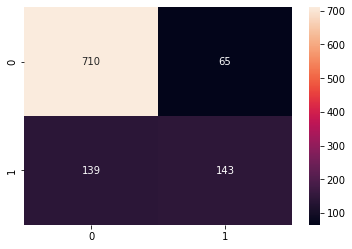

In [126]:
confusion_matrix_1 = matrix_graph(accuracy)
confusion_matrix_1

In [127]:
score, report = model_scores(model, X_test, y_test, y_pred_class)

The model score is:  0.807 

The report is: 
               precision    recall  f1-score   support

           0       0.84      0.92      0.87       775
           1       0.69      0.51      0.58       282

    accuracy                           0.81      1057
   macro avg       0.76      0.71      0.73      1057
weighted avg       0.80      0.81      0.80      1057



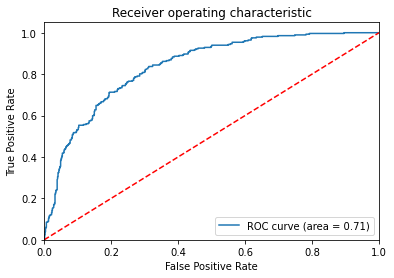

In [128]:
roc_curve = roc_graph(y_test, X_test, model)

### Checking the Data Imbalance

In [129]:
target.value_counts()

Churn
0        5174
1        1869
dtype: int64

The **No** is the **majority class**: 5174 data points \
The **Yes** is the **minority class**: 1869 data points

## Upsampling with SMOTE

In [130]:
def smote_modeling(X, y, models = [], target='offer_accepted', test_size=0.3):
    os = SMOTE(random_state=0)
    X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X, y, test_size=test_size, random_state=42)
    columns = X_smote_train.columns
    os_data_X,os_data_y = os.fit_resample(X_smote_train, y_smote_train)
    os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
    os_data_y = pd.DataFrame(data=os_data_y,columns=[target])
    y_smote = os_data_y[target]
    print("length of oversampled data is ",len(os_data_X))
    print("Number of No in oversampled data",len(os_data_y[os_data_y[target]==0]))
    print("Number of Yes",len(os_data_y[os_data_y[target]==1]))
    print("Proportion of No in oversampled data is ",len(os_data_y[os_data_y[target]==0])/len(os_data_X))
    print("Proportion of Yes data in oversampled data is ",len(os_data_y[os_data_y[target]==1])/len(os_data_X))
    print('\n')
    smodel = model.fit(os_data_X, os_data_y )
    y_smote_pred_class = smodel.predict(X_smote_test)
    smodel_count = pd.Series(y_smote_pred_class).value_counts()
    smote_data_count = y_smote_test.value_counts()
    print(smodel, 'is: \n')
    print('model count is:')
    print(smodel_count)
    print('\n')
    print('data count is:')
    print(smote_data_count)
    print('\n')
    return os_data_X, os_data_y, y_smote, smodel, X_smote_test, y_smote_test, y_smote_pred_class

In [131]:
os_data_X, os_data_y, y_smote, smodel, X_smote_test, y_smote_test, y_smote_pred_class = smote_modeling(X, y, models = [LogisticRegression(multi_class='auto')], target='Churn', test_size=0.15)

length of oversampled data is  8798
Number of No in oversampled data 4399
Number of Yes 4399
Proportion of No in oversampled data is  0.5
Proportion of Yes data in oversampled data is  0.5


LogisticRegression() is: 

model count is:
0    622
1    435
dtype: int64


data count is:
0    775
1    282
Name: Churn, dtype: int64




### Evaluating the model to which the upsampling of the minority class

In [132]:
accuracy_s = model_accuracy(y_smote_test, y_smote_pred_class)
accuracy_s

Classifier accuracy is:  0.74
The model sensitivity is:  0.79
The model's false negative rate is:  0.21
The model specificity is:  0.73
The model's false_positive_rate is:  0.27


array([[563, 212],
       [ 59, 223]], dtype=int64)

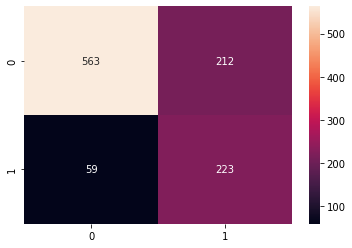

In [133]:
matrix_graph_s = matrix_graph(accuracy_s)

In [134]:
score_s, report_s = model_scores(smodel, X_smote_test, y_smote_test, y_smote_pred_class)

The model score is:  0.7436 

The report is: 
               precision    recall  f1-score   support

           0       0.91      0.73      0.81       775
           1       0.51      0.79      0.62       282

    accuracy                           0.74      1057
   macro avg       0.71      0.76      0.71      1057
weighted avg       0.80      0.74      0.76      1057



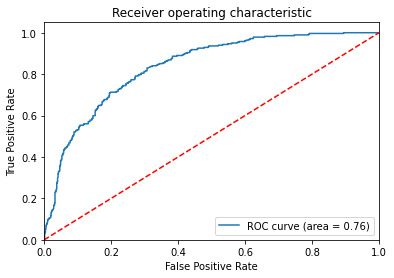

In [135]:
roc_curve_s = roc_graph(y_smote_test, X_smote_test, smodel)

## Combining upsampling technique with downsampling technique to remove noise

### Smote-EEN technique

In [136]:
def SENN_modeling(X, y, models = [], target='offer_accepted', test_size=0.3):
    smote_enn = SMOTEENN(random_state=0)
    X_SENN_train, X_SENN_test, y_SENN_train, y_SENN_test = train_test_split(X, y, test_size=test_size, random_state=42)
    columns = X_SENN_train.columns
    SENN_data_X,SENN_data_y = smote_enn.fit_resample(X_SENN_train, y_SENN_train)
    SENN_data_X = pd.DataFrame(data=SENN_data_X,columns=columns )
    SENN_data_y = pd.DataFrame(data=SENN_data_y,columns=[target])
    y_SENN = SENN_data_y[target]
    SENN_model = model.fit(SENN_data_X, SENN_data_y )
    y_SENN_pred_class = SENN_model.predict(X_SENN_test)
    SENN_model_count = pd.Series(y_SENN_pred_class).value_counts()
    SENN_data_count = y_SENN_test.value_counts()
    print(SENN_model, 'is: \n')
    print('model count is:')
    print(SENN_model_count)
    print('\n')
    print('data count is:')
    print(SENN_data_count)
    print('\n')
    return SENN_data_X, SENN_data_y, y_SENN, SENN_model, X_SENN_test, y_SENN_test, y_SENN_pred_class

In [137]:
SENN_data_X, SENN_data_y, y_SENN, SENN_model, X_SENN_test, y_SENN_test, y_SENN_pred_class = SENN_modeling(X, y, models = [LogisticRegression(multi_class='auto')], target='Churn', test_size=0.13)

LogisticRegression() is: 

model count is:
0    527
1    389
dtype: int64


data count is:
0    672
1    244
Name: Churn, dtype: int64




### Evaluating the Smote-EEN model

In [138]:
accuracy_SENN = model_accuracy(y_SENN_test, y_SENN_pred_class)
accuracy_SENN 

Classifier accuracy is:  0.73
The model sensitivity is:  0.8
The model's false negative rate is:  0.2
The model specificity is:  0.71
The model's false_positive_rate is:  0.29


array([[478, 194],
       [ 49, 195]], dtype=int64)

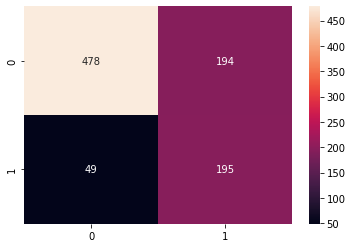

In [139]:
matrix_graph_SENN = matrix_graph(accuracy_SENN)

In [140]:
score_SENN, report_SENN = model_scores(SENN_model, X_SENN_test, y_SENN_test, y_SENN_pred_class)

The model score is:  0.7347 

The report is: 
               precision    recall  f1-score   support

           0       0.91      0.71      0.80       672
           1       0.50      0.80      0.62       244

    accuracy                           0.73       916
   macro avg       0.70      0.76      0.71       916
weighted avg       0.80      0.73      0.75       916



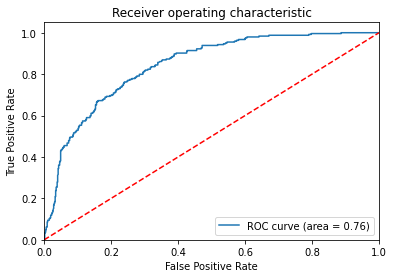

In [141]:
roc_curve_SENN = roc_graph(y_SENN_test, X_SENN_test, SENN_model)

### Smote-Tomek technique

In [142]:
def smote_tomek(X, y, models = [], target='offer_accepted', test_size=0.3):
    smote_tomek = SMOTETomek(random_state=0)
    X_ST_train, X_ST_test, y_ST_train, y_ST_test = train_test_split(X, y, test_size=test_size, random_state=42)
    columns = X_ST_train.columns
    ST_data_X,ST_data_y = smote_tomek.fit_resample(X_ST_train, y_ST_train)
    ST_data_X = pd.DataFrame(data=ST_data_X,columns=columns )
    ST_data_y = pd.DataFrame(data=ST_data_y,columns=[target])
    y_ST = ST_data_y[target]
    ST_model = model.fit(ST_data_X, ST_data_y )
    y_ST_pred_class = ST_model.predict(X_ST_test)
    ST_model_count = pd.Series(y_ST_pred_class).value_counts()
    ST_data_count = y_ST_test.value_counts()
    print(ST_model, 'is: \n')
    print('model count is:')
    print(ST_model_count)
    print('\n')
    print('data count is:')
    print(ST_data_count)
    print('\n')
    return ST_data_X, ST_data_y, y_ST, ST_model, X_ST_test, y_ST_test, y_ST_pred_class

In [143]:
ST_data_X, ST_data_y, y_ST, ST_model, X_ST_test, y_ST_test, y_ST_pred_class = smote_tomek(X, y, models = [LogisticRegression(multi_class='auto')], target='Churn', test_size=0.15)

LogisticRegression() is: 

model count is:
0    623
1    434
dtype: int64


data count is:
0    775
1    282
Name: Churn, dtype: int64




### Evaluating the Smote-Tomek model 

In [144]:
accuracy_ST = model_accuracy(y_ST_test, y_ST_pred_class)
accuracy_ST 

Classifier accuracy is:  0.74
The model sensitivity is:  0.79
The model's false negative rate is:  0.21
The model specificity is:  0.73
The model's false_positive_rate is:  0.27


array([[564, 211],
       [ 59, 223]], dtype=int64)

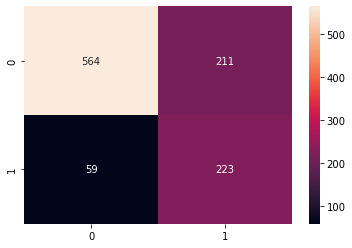

In [145]:
matrix_graph_ST = matrix_graph(accuracy_ST)

In [146]:
score_ST, report_ST = model_scores(ST_model, X_ST_test, y_ST_test, y_ST_pred_class)

The model score is:  0.7446 

The report is: 
               precision    recall  f1-score   support

           0       0.91      0.73      0.81       775
           1       0.51      0.79      0.62       282

    accuracy                           0.74      1057
   macro avg       0.71      0.76      0.71      1057
weighted avg       0.80      0.74      0.76      1057



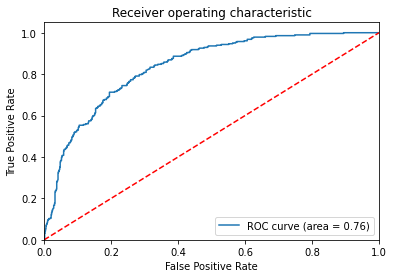

In [147]:
roc_curve_ST = roc_graph(y_ST_test, X_ST_test, ST_model)

### Random Forest

In [148]:
def smote_RF(X, y, models = [], test_size=0.3):
    for model in models:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        sm = SMOTEENN(random_state=42)
        X_sm, y_sm = sm.fit_resample(X_train, y_train)
        model = model.fit(X_sm, y_sm )
        y_pred_class = model.predict(X_test)
        print (round(model.score(X_train, y_train),4))
        print(round(model.score(X_test, y_test),4))
        matrix = metrics.confusion_matrix(y_test, y_pred_class)
        features_ranking = pd.DataFrame(model.feature_importances_, index=X_train.columns).sort_values(by=0, ascending=False)
        features_ranking = features_ranking.rename(columns={0: 'feature_importance'})
    return model, y_pred_class, y_test, X_test, features_ranking, matrix

In [149]:
RF_model, RF_y_pred_class, RF_y_test, RF_X_test, RF_features_ranking, RF_matrix = smote_RF(X, y, models = [RandomForestClassifier()], test_size=0.3)

0.7848
0.7274


#### Observations
The training accuracy is higher -- 0.7874 than the testing accuracy -- 0.8856. \
This means the model is modeling the training data better and not generalizing as well what it’s learning on the overall sample. 

In [150]:
RF_features_ranking

,feature_importance
tenure,0.390406
MonthlyCharges,0.354514
TotalCharges,0.225766
SeniorCitizen,0.029314


MonthlyCharges and tenure are significantly more important than the other two features according to RFC ranking.

###### Confusion matrix

In [151]:
RF_matrix

array([[1118,  421],
       [ 155,  419]], dtype=int64)

True Negative = 1141 \
False Positive = 398\
False Negative = 159\
True Positive = 415

In [152]:
# Number of trees in random forest
n_estimators = np.linspace(2500, 4500, int((4500-100)/50) + 1, dtype=int)

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [12, 13, 15]

# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]

# Method of selecting samples for training each tree
bootstrap = [True]

# Criterion
criterion=['gini']
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
sm = SMOTEENN(random_state=42)
X_sm, y_sm = sm.fit_resample(X_train, y_train)

rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 30, cv = 5,
                               verbose=2,
                               random_state=42, n_jobs = 4)
rf_random.fit(X_sm, y_sm)
rf_random.best_params_

print (' \n', round(rf_random.score(X_train, y_train),4))
print('\n', round(rf_random.score(X_test, y_test),4))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
 
 0.7842

 0.7279


In [154]:
rf_random.best_params_

{'n_estimators': 4386,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 13,
 'criterion': 'gini',
 'bootstrap': True}

In [155]:
rfc = RandomForestClassifier(n_estimators=3181, min_samples_split=2, min_samples_leaf=1, max_depth=13, criterion='gini', bootstrap=True, max_features='sqrt')
rfc.fit(X_sm, y_sm)
rfc_predict = rfc.predict(X_test)
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')
print('Confusion Matrix')
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print('Classification Report')
print(classification_report(y_test, rfc_predict))
print('\n')
print('All AUC Scores')
print(rfc_cv_score)
print('\n')
print('Mean AUC Score')
print('Mean AUC Score - Random Forest: ', rfc_cv_score.mean())

Confusion Matrix
[[1111  428]
 [ 146  428]]


Classification Report
              precision    recall  f1-score   support

           0       0.88      0.72      0.79      1539
           1       0.50      0.75      0.60       574

    accuracy                           0.73      2113
   macro avg       0.69      0.73      0.70      2113
weighted avg       0.78      0.73      0.74      2113



All AUC Scores
[0.80606198 0.8173198  0.80888031 0.81508179 0.80234591 0.78420339
 0.81440127 0.78989232 0.79627944 0.7961398 ]


Mean AUC Score
Mean AUC Score - Random Forest:  0.8030606016403421


In [156]:
features_ranking = pd.DataFrame(rfc.feature_importances_, index=X_train.columns).sort_values(by=0, ascending=False)
features_ranking = features_ranking.rename(columns={0: 'feature_importance'})
features_ranking

,feature_importance
tenure,0.400877
MonthlyCharges,0.351411
TotalCharges,0.219184
SeniorCitizen,0.028528


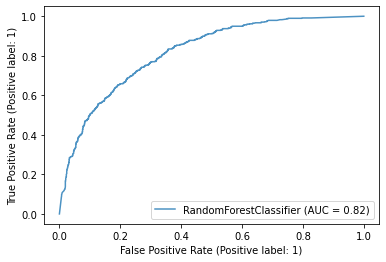

In [157]:
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rfc, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

# Conclusion

Correcting the data imblance with SMOTE gives better results.\
Combining upsampling and downsampling methods give slightly better results than only using an upsampling method. \
The Smote-ENN method slightly improves the recall score and lowers the percentage of false negative rate by only 0.01 point. \
The classification report of the Logistic regression models has slightly better metrics than the RFC's but the RFC Mean AUC score is better.

### Modeling with the categorical data

In [158]:
model, y_pred_class, y_test, X_test = modeling(y, X2, models = [LogisticRegression(multi_class='auto')], test_size=0.15)

LogisticRegression() : 
0    809
1    248
dtype: int64 

The data count is:  0    775
1    282
Name: Churn, dtype: int64 

The matrix is:  [[695  80]
 [114 168]]




In [159]:
accuracy = model_accuracy(y_test, y_pred_class)
accuracy

Classifier accuracy is:  0.82
The model sensitivity is:  0.6
The model's false negative rate is:  0.4
The model specificity is:  0.9
The model's false_positive_rate is:  0.1


array([[695,  80],
       [114, 168]], dtype=int64)

<AxesSubplot:>

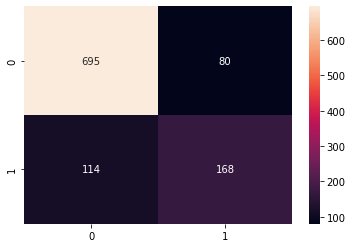

In [160]:
confusion_matrix_1 = matrix_graph(accuracy)
confusion_matrix_1

In [161]:
score, report = model_scores(model, X_test, y_test, y_pred_class)

The model score is:  0.8165 

The report is: 
               precision    recall  f1-score   support

           0       0.86      0.90      0.88       775
           1       0.68      0.60      0.63       282

    accuracy                           0.82      1057
   macro avg       0.77      0.75      0.76      1057
weighted avg       0.81      0.82      0.81      1057



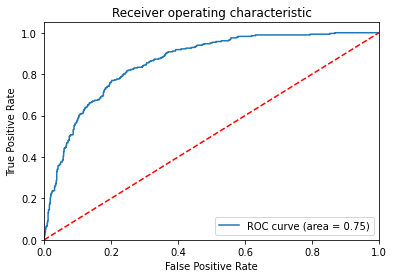

In [162]:
roc_curve = roc_graph(y_test, X_test, model)